# FTP

In [90]:
_FTP_ = 225
_PATH_ = '/home/caster/training_data'

# Load dependencies

In [471]:
%run -i training_functions.py

In [472]:
rides = read_rides(_PATH_, _FTP_)
rides[:10]

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:59: RuntimeWarning: divide by zero encountered in double_scalars


,filename,epoch_day,time,cad,hr,hr_min,hr_max,hr_drift,km,kph,...,tss,if,prev_1_day,prev_2_day,prev_3_day,prev_4_day,prev_5_day,prev_6_day,prev_7_day,resting_days
0,2013_01_01_18_39_26.utf8.json,15706,13,NaN,104.809297,84,113,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2013_01_02_21_37_10.utf8.json,15707,11,82.519553,NaN,NaN,NaN,NaN,6.0847,30.526665,...,13.761139,0.750608,15706,NaN,NaN,NaN,NaN,NaN,NaN,1
0,2013_01_04_16_37_03.utf8.json,15709,110,68.104255,138.144765,103,178,0.134058,47.8464,25.989198,...,196.181671,1.070082,15707,15706,NaN,NaN,NaN,NaN,NaN,2
0,2013_01_06_19_58_20.utf8.json,15711,61,77.129385,122.411090,88,156,-0.197576,30.3666,29.457635,...,68.797399,0.676696,15709,15707,15706,NaN,NaN,NaN,NaN,2
0,2013_01_08_19_35_47.utf8.json,15713,61,84.117591,131.199810,86,166,0.060826,30.5299,29.991929,...,77.116569,0.758524,15711,15709,15707,15706,NaN,NaN,NaN,2
0,2013_01_11_15_57_20.utf8.json,15716,50,68.918543,135.582616,110,180,0.291348,21.3516,25.454828,...,95.615282,1.147383,15713,15711,15709,15707,15706,NaN,NaN,3
0,2013_01_13_09_52_52.utf8.json,15718,232,68.563917,156.381751,0,191,0.123713,106.2880,27.384864,...,428.432063,1.108014,15716,15713,15711,15709,15707,15706,NaN,2
0,2013_01_19_20_31_09.utf8.json,15724,25,81.998673,138.433311,103,164,-0.304288,NaN,NaN,...,29.734249,0.713622,15718,15716,15713,15711,15709,15707,15706,6
0,2013_01_20_18_44_48.utf8.json,15725,56,80.456715,131.461755,75,149,-0.049256,31.7933,33.905662,...,63.645947,0.681921,15724,15718,15716,15713,15711,15709,15707,1
0,2013_01_22_20_44_02.utf8.json,15727,41,79.063720,134.380725,87,169,-0.101574,26.5891,38.065622,...,54.096464,0.791656,15725,15724,15718,15716,15713,15711,15709,2


# LSTM of SS and FTP intervals

In [511]:
input_data = rides[(rides.kilojoules > 0) & (rides.epoch_day > 0) ][['epoch_day', 'kilojoules']]
input_data[:7]

,epoch_day,kilojoules
0,15707,106.7605
0,15709,902.0300
0,15711,513.6505
0,15713,585.2860
0,15716,423.9000
0,15718,2182.2185
0,15724,212.6250


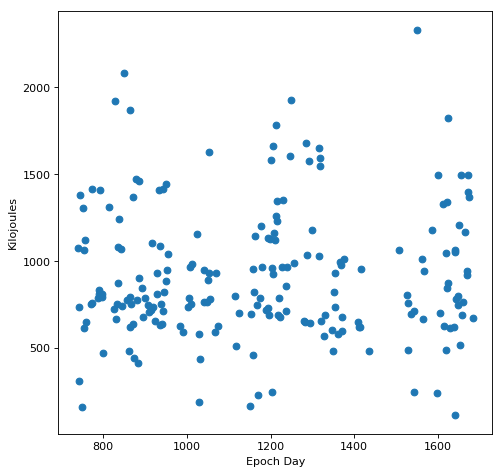

In [515]:
import numpy
import matplotlib.pyplot as plt

input_data.epoch_day = input_data.epoch_day.apply(lambda x: x-input_data.epoch_day.min())

dataset = input_data[(input_data.epoch_day > 700) & (input_data.kilojoules > 100)]

plt.figure(figsize=(7, 7), dpi=80)
plt.scatter(dataset.epoch_day, dataset.kilojoules)
plt.xlabel('Epoch Day')
plt.ylabel('Kilojoules')
plt.show()

In [516]:
dataset.epoch_day = dataset.epoch_day.apply(lambda x: x-dataset.epoch_day.min())

day_watts = dict()
for i in dataset.iterrows():
    day_watts[i[1][0]] = i[1][1]

# Fill holes
result = [None] * (dataset.epoch_day.max()+1)
for i in range(0, dataset.epoch_day.max()+1):
    if day_watts.get(i) is None:
        result[i] = 0
    else:
        result[i] = day_watts.get(i)
        
# shifted = pd.DataFrame({'watts_1':dataset.watts.shift(1)})
# shifted
# dataset = pd.concat([dataset, shifted], axis=1)
# dataset = dataset[1:]
        
dataset = pd.DataFrame(result, columns=['kilojoules'])

print("dataset Shape: (%s, %s)" % (dataset.shape))
dataset[:10]

dataset Shape: (944, 1)


,kilojoules
0,1073.9855
1,0.0000
2,310.8450
3,735.5885
4,0.0000
5,1382.5470
6,0.0000
7,0.0000
8,0.0000
9,0.0000


In [517]:
import numpy
import pandas as pd

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    print('Dataset shape: (%s, %s)' % (dataset.shape))
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

def pdf(data):
    return pd.DataFrame(data)

# fix random seed for reproducibility
numpy.random.seed(7)

print("dataset Shape: (%s, %s)" % (dataset.shape))
pdf(dataset[0:5])

dataset Shape: (944, 1)


,kilojoules
0,1073.9855
1,0.0000
2,310.8450
3,735.5885
4,0.0000


In [518]:
from sklearn.preprocessing import MinMaxScaler
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.values.reshape(-1,1))

print("dataset Shape: (%s, %s)" % (dataset.shape))
pdf(dataset[:5])

dataset Shape: (944, 1)


,0
0,0.461008
1,0.000000
2,0.133430
3,0.315751
4,0.000000


In [519]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

print("trainX Shape: (%s, %s)" % (train.shape))
pdf(train[:5])

trainX Shape: (632, 1)


,0
0,0.461008
1,0.000000
2,0.133430
3,0.315751
4,0.000000


In [533]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print("\ntrainX Shape: (%s, %s)" % (trainX.shape))
pdf(trainX[:5])

Dataset shape: (632, 1)
Dataset shape: (312, 1)

trainX Shape: (630, 1)


,0
0,0.461008
1,0.000000
2,0.133430
3,0.315751
4,0.000000


In [534]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("trainX Shape: (%s, %s, %s)" % (trainX.shape))
trainX[1,0,0]

trainX Shape: (630, 1, 1)


0.0

In [535]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [541]:
import time
start_time = time.time()
model.fit(trainX, trainY, epochs=5000, batch_size=500, verbose=0)
print('Elapsed %.02f' % (time.time() - start_time))

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainYIn = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testYIn = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYIn[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYIn[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Elapsed 39.97
Train Score: 433.35 RMSE
Test Score: 373.53 RMSE


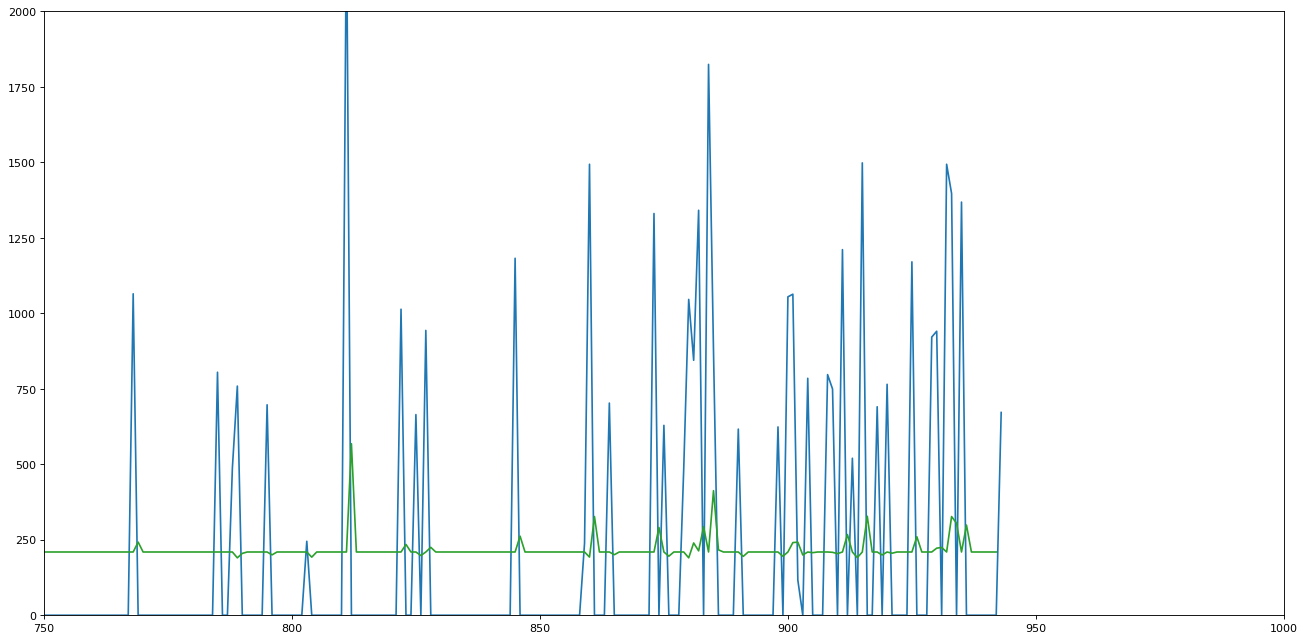

In [558]:
import matplotlib.pyplot as plt

# plot baseline and predictions
plt.figure(figsize=(20, 10), dpi=80)
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.axis([750,1000,0,2000])
plt.show()

In [559]:
scaled = scaler.transform(np.array([950]).reshape(-1,1))
scaler.inverse_transform(model.predict(np.array([scaled])))

array([[ 225.71838379]], dtype=float32)

In [555]:
trainPredictPlot[:750]

array([[          nan],
       [ 243.63496399],
       [ 209.37225342],
       [ 190.23860168],
       [ 202.83789062],
       [ 209.37225342],
       [ 301.67614746],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 196.65858459],
       [ 209.37225342],
       [ 285.7180481 ],
       [ 194.78356934],
       [ 241.93266296],
       [ 209.37225342],
       [ 251.34025574],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 196.55236816],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 204.31072998],
       [ 309.39804077],
       [ 204.73959351],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.37225342],
       [ 209.372